# Reproducing Results from Unveiling Scientific Articles from Paper Mills with Provenance Analysis

The herein notebook reproduce the document-level and panel-level results presented in the work.

As the provenance matrices that generate all the results might take weeks to run on conventional machines,
we are making public available the matrices that we generated from our runs.
The matrices from all methods can be found in this link: https://tinyurl.com/upm-mat-results

In [1]:
from glob import glob
import os
%load_ext autoreload
%autoreload 2
from generate_groups import panel_provenance_groups
import json
from metrics import panel_evaluation, doc_evaluation, rp_eval, rr_eval, global_precision, global_recall, f1, gp_eval, gr_eval
from metrics import global_precision_per_class, global_recall_per_class
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import networkx as nx
from pyvis.network import Network
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Auxiliary functions

In [2]:
def digest_panel_results(method_input, our_annotation):

    all_predicted_graphs = {}
    index = 1
    results = {} 
    results['global'] = {}
    results_rp = pd.DataFrame()
    results_rr = pd.DataFrame()
    results_gp = pd.DataFrame()
    results_gr = pd.DataFrame()
    total_dataset = 0
    for method_name, adj_matrix, _class, dataset in method_input:
        adj_matrix = np.load(adj_matrix)
        with open(f'../dataset/{dataset}/{_class}-dataset.json') as f:
            dataset = json.load(f)
        predicted_graphs = panel_provenance_groups(dataset, adj_matrix)
        metrics = panel_evaluation(predicted_graphs, our_annotation, dataset, adj_matrix, _class)
    
        for pred in predicted_graphs.values():
            all_predicted_graphs[f'GROUP-{index}'] = pred
            index +=1
        results[_class] = {'pairing': metrics["relationship_quality"],
                           'grouping': metrics["grouping_quality"],
                           }
        # Relationship eval
        rp = rp_eval(predicted_graphs, our_annotation, dataset, adj_matrix)
        rr = rr_eval(predicted_graphs, our_annotation, dataset, adj_matrix)
        if len(rp):
            results_rp = pd.concat([results_rp, rp[rp['Class'] == _class]])
        if len(rr):
            results_rr =  pd.concat([results_rr, rr[rr['Class'] == _class]])
        # Grouping eval
        gp = gp_eval(predicted_graphs, our_annotation)
        gr = gr_eval(predicted_graphs, our_annotation)
        if len(gp):
            results_gp = pd.concat([results_gp, gp[gp['Class'] == _class]])
        if len(gr):
            results_gr = pd.concat([results_gr, gr[gr['Class'] == _class]])


    precision = global_precision(all_predicted_graphs, our_annotation, ignore_graphs=True)
    recall =  global_recall(all_predicted_graphs, our_annotation, ignore_graphs=True)
    results['global']['classification'] = f1(precision, recall)
    results['global']['pairing'] = f1(results_rp['Precision'].mean(), results_rr['Recall'].mean())
    results['global']['grouping'] = f1(results_gp['Precision'].mean(), results_gr['Recall'].mean())
    return results

# Creates document dataset
def create_doc_dataset(data_version):
    doc_dataset = set()
    for _class in ['Microscopy', 'Blots', 'FlowCytometry', 'BodyImaging']:
        if not os.path.isfile(f'../dataset/{data_version}/{_class}-dataset.json'):
            continue
        for data in glob(f'../dataset/{data_version}/{_class}-dataset.json'):
            with open(data) as f:
                dataset = json.load(f)
            doc_data = [d['doc_id'] for d in dataset.values()]
            doc_dataset = doc_dataset.union(doc_data)
    doc_dataset = sorted(list(doc_dataset))
    return doc_dataset

def create_doc_adj_matrix(method_input, doc_dataset):
    
    doc_adjacency_matrix = np.zeros((len(doc_dataset), len(doc_dataset)))

    for matrix, dataset in method_input:
        panel_adjacency_matrix = np.load(matrix)
        with open(dataset) as f:
            panel_dataset = json.load(f)
            
        for i in range(len(panel_adjacency_matrix)):
            for j in range(i+1,len(panel_adjacency_matrix)):
                if panel_adjacency_matrix[i,j]:
                    doc_i = doc_dataset.index(panel_dataset[str(i)]['doc_id'])
                    doc_j = doc_dataset.index(panel_dataset[str(j)]['doc_id'])
                    
                    # Mark that the document share elements
                    doc_adjacency_matrix[doc_i,doc_j] += 1
                    doc_adjacency_matrix[doc_j,doc_i] += 1
    return doc_adjacency_matrix

# Create Doc Provenance Groups


def create_doc_provenance(doc_adjacency_matrix, doc_dataset):
    doc_provenance_graphs = []
    # Connect components
    G = nx.from_numpy_array(doc_adjacency_matrix)
    # get all connected componentes of the grap
    components = nx.connected_components(G)

    # Insert all connected components that have more than 1 node
    # into a list
    doc_provenance_graphs = []
    for cc in components:
        graph = G.subgraph(cc)
        if graph.number_of_nodes() > 1:
            nt = Network()
            nt.from_nx(graph)
            for index, node in enumerate(nt.nodes):
                nt.nodes[index]['title'] = doc_dataset[node['id']]
            doc_provenance_graphs.append(nt)

    doc_provenance = {}
    for graph_id, graph in enumerate(doc_provenance_graphs):
        doc_provenance['GROUP-%d'%(graph_id+1)] = {}
        doc_provenance['GROUP-%d'%(graph_id+1)] = list(set([ i['title'] for i in graph.nodes]))

    return doc_provenance

def digest_doc_results(method_input, doc_dataset, doc_annotation):
    
    
    provenance_matrix = create_doc_adj_matrix(method_input, doc_dataset)
    predicted_graphs = create_doc_provenance(provenance_matrix, doc_dataset)
    # update format doc_dataset
    dict_doc_dataset = {}
    index = 0
    for d in doc_dataset:
        dict_doc_dataset[str(index)] = {'doc_id':d}
        index +=1
    # Evaluate results
    metrics = doc_evaluation(predicted_graphs, doc_annotation,
                              dict_doc_dataset, provenance_matrix)
    
    results = {}
    results['pairing'] = metrics["relationship_quality"]
    results['grouping'] = metrics["grouping_quality"]
    results['classification'] = metrics['global_quality']
    
    return results


import seaborn as sns # pip install seaborn
def plot_results(data, datay_str, ylabel):
    
    plt.figure(figsize=(30,20))
    # sns.set_theme(style="darkgrid")

    sns.set(font_scale=1.5)

    colors = [(230, 198, 84),
               (227, 146, 58),
               (112,162,23)
    ]
    colors = [(r/255, g/255, b/255) for r,g,b in colors]
    sns.set_style("darkgrid", {"grid.color": ".2", "grid.linestyle": ":"})
    # first blot the Blots, than the flow cytometry and finally the microscopy
    ax = sns.catplot(x="Method" ,y=datay_str, hue="Panel Class", 
                     col="Dataset", kind='bar', data=data, palette=colors,
                    )

    ax.set(xlabel='Methods', ylabel=ylabel)
    

    # plt.legend(loc='upper left')
    # plt.tight_layout()
    plt.savefig(f'{ylabel.lower().replace(" ","-")}-per-class.pdf')

def sort_method(x):
    sort_order = []
    for i in x:
        if i == 'BSRD':
            index =1
        elif i == 'SILA':
             index =2
        else:
             index =3
        sort_order.append(index)
    return sort_order

def digest_panel_results_per_class(method_input, our_annotation):

    all_predicted_graphs = {}
    index = 1
    results = {} 
    for method_name, adj_matrix, _class, dataset in method_input:
        adj_matrix = np.load(adj_matrix)
        with open(f'../dataset/{dataset}/{_class}-dataset.json') as f:
            dataset = json.load(f)
        predicted_graphs = panel_provenance_groups(dataset, adj_matrix)
        metrics = panel_evaluation(predicted_graphs, our_annotation, dataset, adj_matrix, _class)

        precision = global_precision_per_class(predicted_graphs, our_annotation, _class)
        recall =  global_recall_per_class(predicted_graphs, our_annotation, _class)
        if precision and recall:
            f1_result = f1(precision, recall)
        else:
            f1_result = 0
        results[_class] = {'pairing': metrics["relationship_quality"],
                           'grouping': metrics["grouping_quality"],
                           'classification': f1_result}
    return results

def organize_results(scores, dataset,
                     df_pairing = pd.DataFrame(columns=['Dataset', 'Method', 'Panel Class', 'pairing']),
                      df_grouping = pd.DataFrame(columns=['Dataset', 'Method', 'Panel Class', 'grouping']),
                      df_classification = pd.DataFrame(columns=['Dataset', 'Method', 'Panel Class', 'classification'])):
    

    for method, results in  scores.items():
        for _class, results_per_class in results.items():
            df_pairing.loc[len(df_pairing)] = [dataset, method, _class, results_per_class['pairing']]
            df_grouping.loc[len(df_grouping)] = [dataset, method, _class, results_per_class['grouping']]
            df_classification.loc[len(df_classification)] = [dataset, method, _class, results_per_class['classification']]
    return df_pairing, df_grouping, df_classification

# Panel Evaluation

#### Load Data

In [3]:

sila_spp = [('SILA', 'adjacency-matrices/SPP/sila/Microscopy.npy','Microscopy', 'spm'),
('SILA', 'adjacency-matrices/SPP/sila/Blots.npy','Blots', 'spm'),
('SILA', 'adjacency-matrices/SPP/sila/FlowCytometry.npy','FlowCytometry', 'spm')]

sila_spp_v1 = [('SILA', 'adjacency-matrices/SPP-v1/sila/Microscopy.npy','Microscopy', 'spm-v1'),
('SILA', 'adjacency-matrices/SPP-v1/sila/Blots.npy','Blots', 'spm-v1'),
('SILA', 'adjacency-matrices/SPP-v1/sila/FlowCytometry.npy','FlowCytometry', 'spm-v1'),
('SILA', 'adjacency-matrices/SPP-v1/sila/BodyImaging.npy','BodyImaging', 'spm-v1')]

sila_spp_v2 = [('SILA', 'adjacency-matrices/SPP-v2/sila/Microscopy.npy','Microscopy', 'spm-v2'),
('SILA', 'adjacency-matrices/SPP-v2/sila/Blots.npy','Blots', 'spm-v2'),
('SILA', 'adjacency-matrices/SPP-v2/sila/FlowCytometry.npy','FlowCytometry', 'spm-v2'),
('SILA', 'adjacency-matrices/SPP-v2/sila/BodyImaging.npy','BodyImaging', 'spm-v2')]

ours_spp = [('Ours', 'adjacency-matrices/SPP/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-Microscopy.npy','Microscopy', 'spm'),
('Ours', 'adjacency-matrices/SPP/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-Blots.npy','Blots', 'spm'),
('Ours', 'adjacency-matrices/SPP/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-FlowCytometry.npy','FlowCytometry', 'spm')]

ours_spp_v1 = [('Ours', 'adjacency-matrices/SPP-v1/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-Microscopy.npy','Microscopy', 'spm-v1'),
('Ours', 'adjacency-matrices/SPP-v1/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-Blots.npy','Blots', 'spm-v1'),
('Ours', 'adjacency-matrices/SPP-v1/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-FlowCytometry.npy','FlowCytometry', 'spm-v1'),
('Ours', 'adjacency-matrices/SPP-v1/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-BodyImaging.npy','BodyImaging', 'spm-v1')

]

ours_spp_v2 = [('Ours', 'adjacency-matrices/SPP-v2/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-Microscopy.npy','Microscopy', 'spm-v2'),
('Ours', 'adjacency-matrices/SPP-v2/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-Blots.npy','Blots', 'spm-v2'),
('Ours', 'adjacency-matrices/SPP-v2/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-FlowCytometry.npy','FlowCytometry', 'spm-v2'),
('Ours', 'adjacency-matrices/SPP-v2/ours/vlfeat_sift_heq-BF-CV_MAGSAC-400-20-300-0.01-BodyImaging.npy','BodyImaging', 'spm-v2')]

acuna_spp = [('Acuna', 'adjacency-matrices/SPP/acuna/Microscopy-adjacency_matrix.npy','Microscopy', 'spm'),
('Acuna', 'adjacency-matrices/SPP/acuna/Blots-adjacency_matrix.npy','Blots', 'spm'),
('Acuna', 'adjacency-matrices/SPP/acuna/FlowCytometry-adjacency_matrix.npy','FlowCytometry', 'spm')]

acuna_spp_v1 = [('Acuna', 'adjacency-matrices/SPP-v1/acuna/Microscopy-adjacency_matrix.npy','Microscopy', 'spm-v1'),
('Acuna', 'adjacency-matrices/SPP-v1/acuna/Blots-adjacency_matrix.npy','Blots', 'spm-v1'),
('Acuna', 'adjacency-matrices/SPP-v1/acuna/FlowCytometry-adjacency_matrix.npy','FlowCytometry', 'spm-v1'),
('Acuna', 'adjacency-matrices/SPP-v1/acuna/BodyImaging-adjacency_matrix.npy','BodyImaging', 'spm-v1')]

acuna_spp_v2 = [('Acuna', 'adjacency-matrices/SPP-v2/acuna/Microscopy-adjacency_matrix.npy','Microscopy', 'spm-v2'),
('Acuna', 'adjacency-matrices/SPP-v2/acuna/Blots-adjacency_matrix.npy','Blots', 'spm-v2'),
('Acuna', 'adjacency-matrices/SPP-v2/acuna/FlowCytometry-adjacency_matrix.npy','FlowCytometry', 'spm-v2'),
('Acuna', 'adjacency-matrices/SPP-v2/acuna/BodyImaging-adjacency_matrix.npy','BodyImaging', 'spm-v2')]


#### Load Ground Truth

In [4]:
with open("our_annotation.json") as f:
    our_annotation = json.load(f)

In [5]:
# SPP results
spp_results = {}
spp_results['SILA'] = digest_panel_results(sila_spp, our_annotation)["global"]
spp_results['Ours'] = digest_panel_results(ours_spp, our_annotation)["global"]
spp_results['Acuna'] = digest_panel_results(acuna_spp, our_annotation)["global"]

# SPP-v1 results
spp_v1_results = {}
spp_v1_results['SILA'] = digest_panel_results(sila_spp_v1, our_annotation)["global"]
spp_v1_results['Ours'] = digest_panel_results(ours_spp_v1, our_annotation)["global"]
spp_v1_results['Acuna'] = digest_panel_results(acuna_spp_v1, our_annotation)["global"]

# SPP-v2 results
spp_v2_results = {}
spp_v2_results['SILA'] = digest_panel_results(sila_spp_v2, our_annotation)["global"]
spp_v2_results['Ours'] = digest_panel_results(ours_spp_v2, our_annotation)["global"]
spp_v2_results['Acuna'] = digest_panel_results(acuna_spp_v2, our_annotation)["global"]

#### Panel Results

In [17]:
# organize results on tables
df_spp_results = pd.DataFrame(spp_results)
df_spp_v1_results = pd.DataFrame(spp_v1_results)
df_spp_v2_results = pd.DataFrame(spp_v2_results)

print("SPP Panel Level Results")
print(df_spp_results.to_string())
print("\n\n")

print("SPP-v1 Panel Level Results")	
print(df_spp_v1_results.to_string())
print("\n\n")

print("SPP-v2 Panel Level Results")
print(df_spp_v2_results.to_string())

SPP Panel Level Results
                    SILA      Ours     Acuna
classification  0.844714  0.869003  0.873653
pairing         0.728208  0.741062  0.536097
grouping        0.806920  0.836365  0.812907



SPP-v1 Panel Level Results
                    SILA      Ours     Acuna
classification  0.772407  0.870741  0.441642
pairing         0.660765  0.741203  0.252193
grouping        0.738424  0.838061  0.242926



SPP-v2 Panel Level Results
                    SILA      Ours     Acuna
classification  0.439920  0.838474  0.084978
pairing         0.363511  0.710482  0.044306
grouping        0.422078  0.806617  0.016710


# Document-Level Evaluation

#### Load Document Dataset

In [7]:

spp_doc_dataset = create_doc_dataset('spm')
spp_v1_doc_dataset = create_doc_dataset('spm-v1')
spp_v2_doc_dataset = create_doc_dataset('spm-v2')

# Load doc annotation
with open("document-level-annotation.json") as f:
    doc_annotation = json.load(f)

In [8]:
sila_doc_spp = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in sila_spp]
ours_doc_spp = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in ours_spp]
acuna_doc_spp = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in acuna_spp]

sila_doc_spp_v1 = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in sila_spp_v1]
ours_doc_spp_v1 = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in ours_spp_v1]
acuna_doc_spp_v1 = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in acuna_spp_v1]

sila_doc_spp_v2 = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in sila_spp_v2]
ours_doc_spp_v2 = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in ours_spp_v2]
acuna_doc_spp_v2 = [(data[1], f'../dataset/{data[3]}/{data[2]}-dataset.json') for data in acuna_spp_v2]


#### Document Results

In [9]:
# SPP doc results
spp_doc_results = {}
spp_doc_results['SILA'] = digest_doc_results(sila_doc_spp, spp_doc_dataset, doc_annotation)
spp_doc_results['Ours'] = digest_doc_results(ours_doc_spp, spp_doc_dataset, doc_annotation)
spp_doc_results['Acuna'] = digest_doc_results(acuna_doc_spp, spp_doc_dataset, doc_annotation)

# SPP-v1 doc results
spp_v1_doc_results = {}
spp_v1_doc_results['SILA'] = digest_doc_results(sila_doc_spp_v1, spp_v1_doc_dataset, doc_annotation)
spp_v1_doc_results['Ours'] = digest_doc_results(ours_doc_spp_v1, spp_v1_doc_dataset, doc_annotation)
spp_v1_doc_results['Acuna'] = digest_doc_results(acuna_doc_spp_v1, spp_v1_doc_dataset, doc_annotation)

# SPP-v2 doc results
spp_v2_doc_results = {}
spp_v2_doc_results['SILA'] = digest_doc_results(sila_doc_spp_v2, spp_v2_doc_dataset, doc_annotation)
spp_v2_doc_results['Ours'] = digest_doc_results(ours_doc_spp_v2, spp_v2_doc_dataset, doc_annotation)
spp_v2_doc_results['Acuna'] = digest_doc_results(acuna_doc_spp_v2, spp_v2_doc_dataset, doc_annotation)


In [16]:
# organize results on tables
df_spp_doc_results = pd.DataFrame(spp_doc_results)
df_spp_v1_doc_results = pd.DataFrame(spp_v1_doc_results)
df_spp_v2_doc_results = pd.DataFrame(spp_v2_doc_results)

print("SPP Document Level Results\n")
print(df_spp_doc_results.to_string())
print("\n\n")
print("SPP-v1 Document Level Results")	
print(df_spp_v1_doc_results.to_string())
print("\n\n")
print("SPP-v2 Document Level Results")
print(df_spp_v2_doc_results.to_string())

SPP Document Level Results

                    SILA      Ours     Acuna
pairing         0.843025  0.838305  0.718205
grouping        0.991701  1.000000  1.000000
classification  0.995851  1.000000  1.000000



SPP-v1 Document Level Results
                    SILA      Ours     Acuna
pairing         0.843025  0.834951  0.280790
grouping        0.991701  1.000000  0.152643
classification  0.995851  1.000000  0.440801



SPP-v2 Document Level Results
                    SILA      Ours     Acuna
pairing         0.732390  0.768822  0.031198
grouping        0.860189  0.920152  0.002544
classification  0.863309  0.920152  0.068750


### Image analysis per class ['Microscopy', 'Blots', 'FlowCytometry']

In [11]:
# SPP results
spp_per_class_results = {}
spp_per_class_results['SILA'] = digest_panel_results_per_class(sila_spp, our_annotation)
spp_per_class_results['Ours'] = digest_panel_results_per_class(ours_spp, our_annotation)
spp_per_class_results['Acuna'] = digest_panel_results_per_class(acuna_spp, our_annotation)

df_pairing, df_grouping, df_classification = organize_results(spp_per_class_results, "SPP")

# SPP-v1 results
spp_per_class_v1_results = {}
spp_per_class_v1_results['SILA'] = digest_panel_results_per_class(sila_spp_v1, our_annotation)
spp_per_class_v1_results['Ours'] = digest_panel_results_per_class(ours_spp_v1, our_annotation)
spp_per_class_v1_results['Acuna'] = digest_panel_results_per_class(acuna_spp_v1, our_annotation)

df_pairing, df_grouping, df_classification = organize_results(spp_per_class_v1_results, "SPP-v1",
                                                              df_pairing, df_grouping, df_classification)

# SPP-v2 results
spp_per_class_v2_results = {}
spp_per_class_v2_results['SILA'] = digest_panel_results_per_class(sila_spp_v2, our_annotation)
spp_per_class_v2_results['Ours'] = digest_panel_results_per_class(ours_spp_v2, our_annotation)
spp_per_class_v2_results['Acuna'] = digest_panel_results_per_class(acuna_spp_v2, our_annotation)

df_pairing, df_grouping, df_classification = organize_results(spp_per_class_v2_results, "SPP-v2",
                                                              df_pairing, df_grouping, df_classification)
# exclude rows which Panel class equal BodyImaging
df_pairing = df_pairing[df_pairing['Panel Class'] != 'BodyImaging']
df_grouping = df_grouping[df_grouping['Panel Class'] != 'BodyImaging']
df_classification = df_classification[df_classification['Panel Class'] != 'BodyImaging']

# remove duplicates
df_pairing = df_pairing.drop_duplicates()
df_grouping = df_grouping.drop_duplicates()
df_classification = df_classification.drop_duplicates()

<Figure size 3000x2000 with 0 Axes>

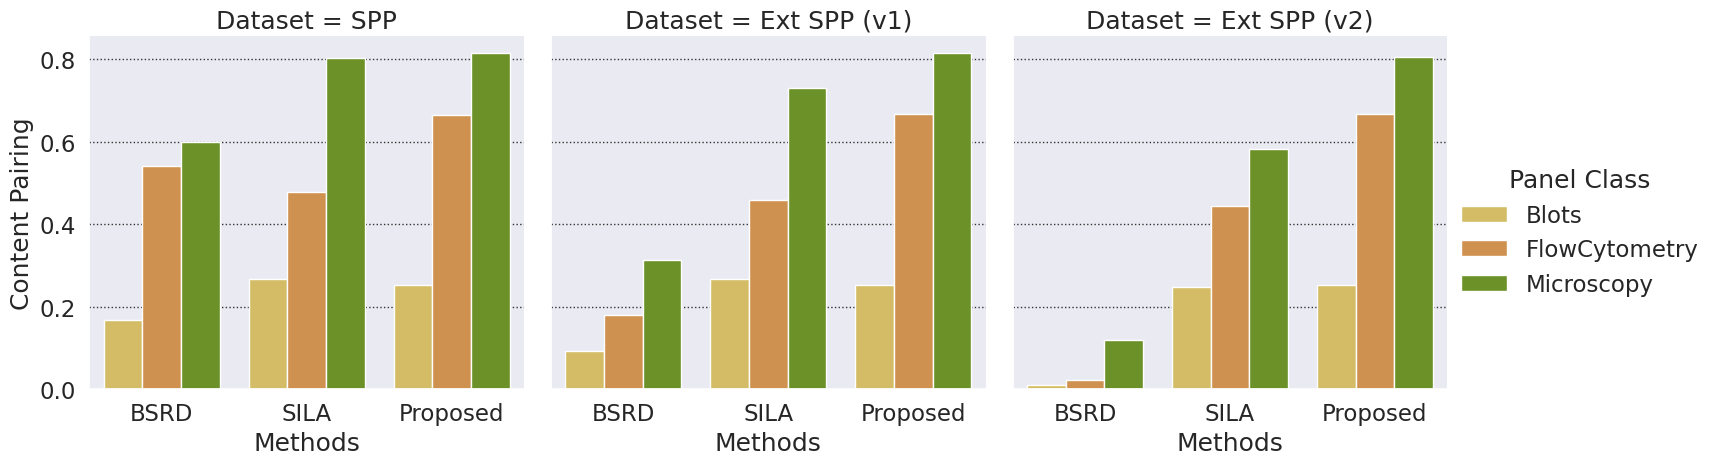

In [12]:
# Plot results by class and method
# sort alphabetically by class
df_pairing.replace({'Method': {'Acuna': 'BSRD'}}, inplace=True)
df_pairing.replace({'Method': {'Ours': 'Proposed'}}, inplace=True)
df_pairing.replace({'Dataset': {'SPP-v1': 'Ext SPP (v1)'}}, inplace=True)
df_pairing.replace({'Dataset': {'SPP-v2': 'Ext SPP (v2)'}}, inplace=True)

df_pairing = df_pairing.groupby('Method').apply(lambda x: x.sort_values(by='Panel Class'))
bsrd = df_pairing[df_pairing['Method'] == 'BSRD']
sila = df_pairing[df_pairing['Method'] == 'SILA']
proposed = df_pairing[df_pairing['Method'] == 'Proposed']
df_pairing = pd.concat([bsrd, sila, proposed])
df_pairing.reset_index(drop=True, inplace=True)

# Sort method with lambda function first B than S than P
plot_results(df_pairing, 'pairing', 'Content Pairing')

<Figure size 3000x2000 with 0 Axes>

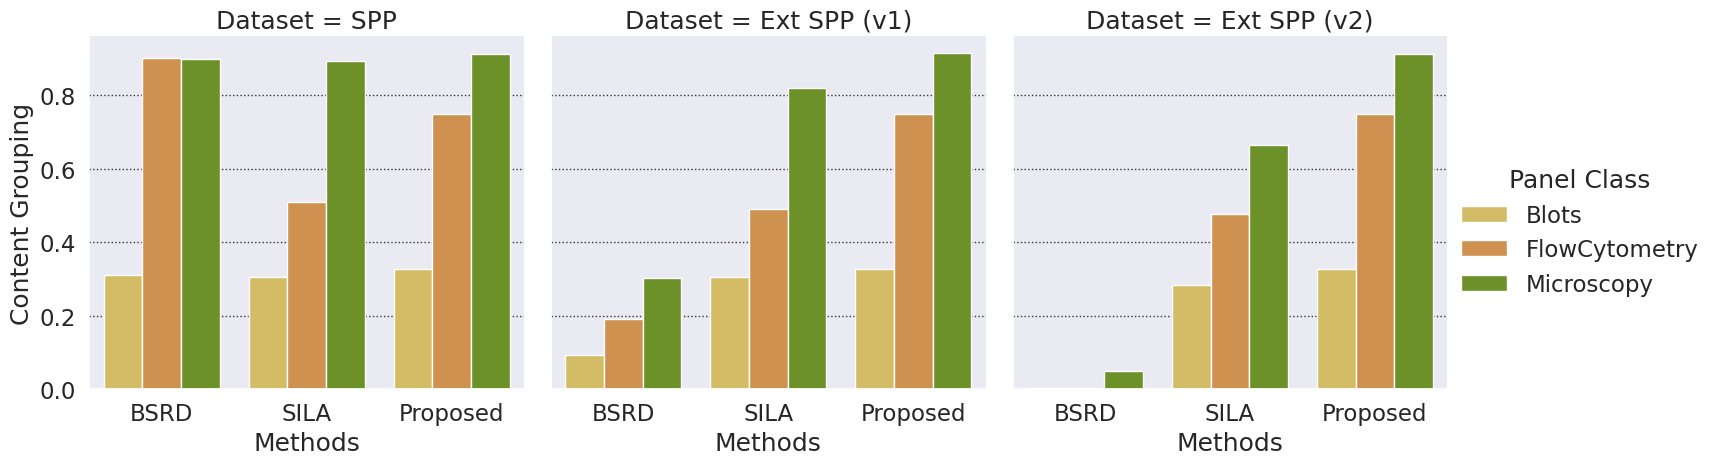

In [13]:
# Plot results by class and method
# sort alphabetically by class
df_grouping.replace({'Method': {'Acuna': 'BSRD'}}, inplace=True)
df_grouping.replace({'Method': {'Ours': 'Proposed'}}, inplace=True)
df_grouping.replace({'Dataset': {'SPP-v1': 'Ext SPP (v1)'}}, inplace=True)
df_grouping.replace({'Dataset': {'SPP-v2': 'Ext SPP (v2)'}}, inplace=True)

df_grouping = df_grouping.groupby('Method').apply(lambda x: x.sort_values(by='Panel Class'))
bsrd = df_grouping[df_grouping['Method'] == 'BSRD']
sila = df_grouping[df_grouping['Method'] == 'SILA']
proposed = df_grouping[df_grouping['Method'] == 'Proposed']
df_grouping = pd.concat([bsrd, sila, proposed])
df_grouping.reset_index(drop=True, inplace=True)

# Sort method with lambda function first B than S than P
plot_results(df_grouping, 'grouping', 'Content Grouping')

<Figure size 3000x2000 with 0 Axes>

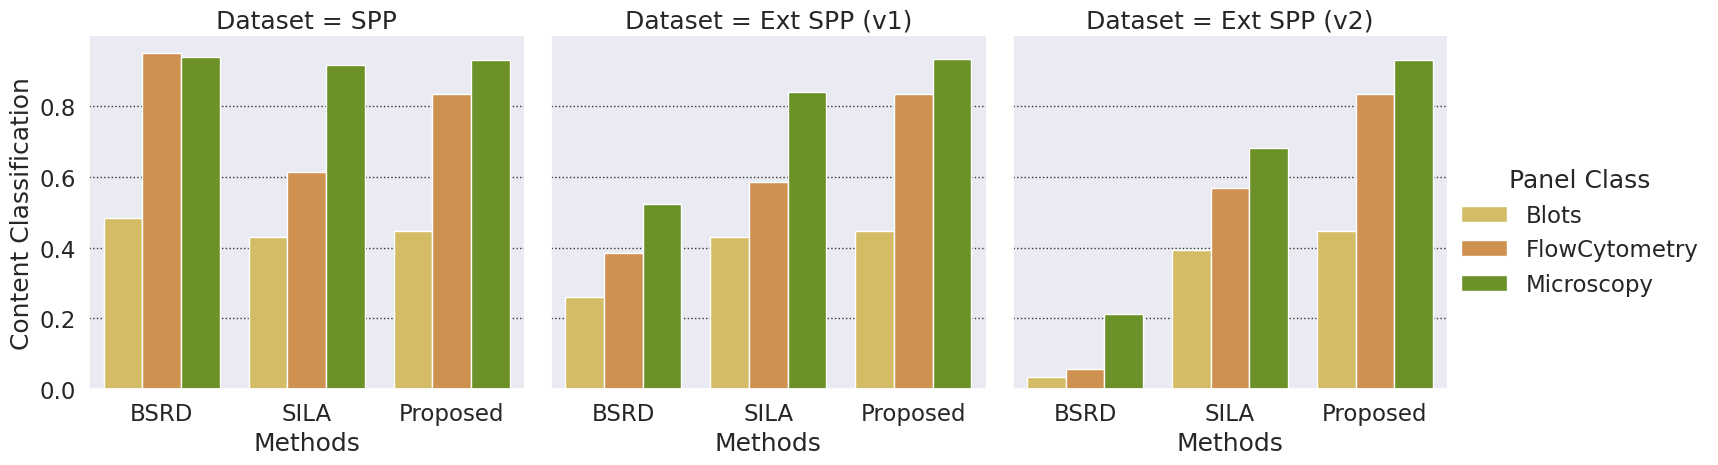

In [14]:
# Plot results by class and method
# sort alphabetically by class
df_classification.replace({'Method': {'Acuna': 'BSRD'}}, inplace=True)
df_classification.replace({'Method': {'Ours': 'Proposed'}}, inplace=True)
df_classification.replace({'Dataset': {'SPP-v1': 'Ext SPP (v1)'}}, inplace=True)
df_classification.replace({'Dataset': {'SPP-v2': 'Ext SPP (v2)'}}, inplace=True)

df_classification = df_classification.groupby('Method').apply(lambda x: x.sort_values(by='Panel Class'))
bsrd = df_classification[df_classification['Method'] == 'BSRD']
sila = df_classification[df_classification['Method'] == 'SILA']
proposed = df_classification[df_classification['Method'] == 'Proposed']
df_classification = pd.concat([bsrd, sila, proposed])
df_classification.reset_index(drop=True, inplace=True)

# Sort method with lambda function first B than S than P
plot_results(df_classification, 'classification', 'Content Classification')